#**Logistic Regression**
##1. Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install fancyimpute

###1.1 Import dependencies

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_score,  roc_curve, fbeta_score, make_scorer, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.impute import SimpleImputer
from fancyimpute import IterativeImputer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

###1. 2 Define Function

In [ ]:
# add plot statistics
def add_stats_to_plot(data, x, ax):
    mean_val = data[x].mean()
    std_val = data[x].std()
    median_val = data[x].median()
    mode_val = data[x].mode().iloc[0]
    min_val = data[x].min()
    max_val = data[x].max()

    stats_text = (
        f"Mean: {mean_val:.2f}\n"
        f"Std: {std_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Mode: {mode_val:.2f}\n"
        f"Min: {min_val:.2f}\n"
        f"Max: {max_val:.2f}"
    )

    bbox_props = dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0.5)

    ax.text(0.5, 0.8, stats_text, transform=ax.transAxes, fontsize=9, ha='center', va='center',
            bbox=bbox_props, color='black')


# Plot the ROC curve
def plot_roc_curve_custom(model, X, y, title, ax):
    y_pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    auc_score = roc_auc_score(y, y_pred_proba)
    ax.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')


# Function to evaluate models with default hyperparameters
def train_and_evaluate_models(X_train, X_test, y_train, y_test, X_train_resampled, y_train_resampled):
    # List to save results
    results = []

    models = {
        "Random Forest": RandomForestClassifier(random_state=42),
        "LOG Reg": LogisticRegression(max_iter=1000, penalty='l2', random_state=42),
        "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        "LGBoost": LGBMClassifier(random_state=42)
    }

    print("--- Đánh giá các mô hình với dữ liệu GỐC (Mất cân bằng) ---")
    for model_name, model in models.items():
        print(f"\n*** Đang huấn luyện và đánh giá: {model_name} (Dữ liệu gốc) ***")
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]

        # Tính toán các metrics cơ bản
        recall_test = recall_score(y_test, y_pred_test, average='weighted')
        precision_test = precision_score(y_test, y_pred_test, average='weighted')
        auc_test = roc_auc_score(y_test, y_pred_proba_test) # AUC thường không cần average
        f1_test = f1_score(y_test, y_pred_test, average='weighted')

        print(f"\nĐánh giá chi tiết {model_name} trên tập Test (Dữ liệu gốc):")
        print("Classification Report:")
        print(classification_report(y_test, y_pred_test, target_names=class_labels))

        print("Confusion Matrix:")
        cm_test = confusion_matrix(y_test, y_pred_test)
        print(cm_test)
        # Vẽ heatmap
        plot_confusion_matrix_heatmap(cm_test, class_labels, f'Confusion Matrix - {model_name} (Test - Gốc)')

        # Lưu kết quả tóm tắt
        results.append({
            "Model": model_name, "Data": "Unbalanced - Test",
            "Recall": recall_test, "Precision": precision_test,
            "AUC": auc_test, "F1-Score": f1_test
        })


    print("\n\n--- Đánh giá các mô hình với dữ liệu SMOTE ---")
    for model_name, model in models.items():
        print(f"\n*** Đang huấn luyện và đánh giá: {model_name} (Dữ liệu SMOTE) ***")
        # Huấn luyện lại trên dữ liệu SMOTE
        model.fit(X_train_resampled, y_train_resampled)
        # Dự đoán trên tập test GỐC
        y_pred_test_smote = model.predict(X_test)
        y_pred_proba_test_smote = model.predict_proba(X_test)[:, 1] # Lấy xác suất cho AUC

        # Tính toán các metrics cơ bản (sử dụng average='macro' như code gốc cho SMOTE)
        recall_test_smote = recall_score(y_test, y_pred_test_smote, pos_label=1)
        precision_test_smote = precision_score(y_test, y_pred_test_smote, pos_label=1)
        auc_test_smote = roc_auc_score(y_test, y_pred_proba_test_smote) # AUC thường không cần average
        f1_test_smote = f1_score(y_test, y_pred_test_smote, pos_label=1)


        print(f"\nĐánh giá chi tiết {model_name} (Huấn luyện SMOTE) trên tập Test:")
        print("Classification Report:")

        print(classification_report(y_test, y_pred_test_smote, target_names=class_labels))

        print("Confusion Matrix:")
        cm_test_smote = confusion_matrix(y_test, y_pred_test_smote)
        print(cm_test_smote)
        # Vẽ heatmap
        plot_confusion_matrix_heatmap(cm_test_smote, class_labels, f'Confusion Matrix - {model_name} (Test - SMOTE Trained)')


        # Lưu kết quả tóm tắt
        results.append({
            "Model": model_name, "Data": "SMOTE - Test",
            "Recall": recall_test_smote, "Precision": precision_test_smote,
            "AUC": auc_test_smote, "F1-Score": f1_test_smote
        })



    print("\n--- Bảng tóm tắt kết quả trên tập Test ---")
    results_df = pd.DataFrame(results)
    print(results_df)

    return results_df

def plot_confusion_matrix_heatmap(cm, labels, title):
    """Vẽ heatmap cho confusion matrix."""
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Giá trị thực tế')
    plt.xlabel('Giá trị dự đoán')
    plt.show()

# Định nghĩa nhãn lớp
class_labels = ['Không vỡ nợ (0)', 'Vỡ nợ (1)']

def find_optimal_threshold_f1_label1(model, X_val, y_val_true):
    """
    Tìm ngưỡng tối ưu để tối đa hóa F1-score cho lớp 1 (positive class)
    dựa trên đường Precision-Recall.

    Args:
        model: Mô hình đã huấn luyện.
        X_val: Dữ liệu đặc trưng của tập validation.
        y_val_true: Nhãn thực tế của tập validation.

    Returns:
        best_threshold: Ngưỡng tối ưu.
        best_f1: F1-score tốt nhất cho lớp 1 tại ngưỡng đó.
    """
    # Lấy xác suất dự đoán cho lớp 1
    y_pred_proba_val = model.predict_proba(X_val)[:, 1]

    # Tính precision, recall, thresholds
    precision, recall, thresholds = precision_recall_curve(y_val_true, y_pred_proba_val)

    # Tính F1-score cho từng ngưỡng (cho lớp 1)
    # thresholds có ít hơn 1 phần tử so với precision và recall,
    # nên chúng ta bỏ qua phần tử cuối của precision và recall
    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    # Xử lý trường hợp chia cho 0 (nếu precision + recall = 0)
    f1_scores = np.nan_to_num(f1_scores)


    # Tìm vị trí (index) của F1-score cao nhất
    best_f1_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]

    print(f"Ngưỡng tối ưu (cho F1 lớp 1): {best_threshold:.4f}")
    print(f"F1-score tốt nhất cho lớp 1 tại ngưỡng này: {best_f1:.4f}")

    # (Tùy chọn) Vẽ đường Precision-Recall và điểm tối ưu
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    # Đánh dấu điểm ngưỡng tối ưu
    plt.scatter(recall[best_f1_idx], precision[best_f1_idx], marker='o', color='red',
                label=f'Optimal (F1={best_f1:.2f}, Thr={best_threshold:.2f})', s=100, zorder=5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve và Ngưỡng Tối ưu cho F1 Lớp 1')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_threshold, best_f1

In [ ]:
DATA_PATH = '/content/drive/MyDrive/DataSet/GiveMeSomeCredit/'
try:
    df_train_raw = pd.read_csv(DATA_PATH + 'cs-training.csv', header=0, index_col=0)
    print("Tải dữ liệu thành công!")
    print(f"Kích thước tập huấn luyện ban đầu: {df_train_raw.shape}")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file CSV tại đường dẫn: {DATA_PATH}")
    print("Vui lòng kiểm tra lại biến DATA_PATH và cấu trúc thư mục trên Google Drive.")
    # Thoát nếu không tải được file
    import sys
    sys.exit()

# Tạo bản sao để tránh thay đổi dữ liệu gốc
raw_data = df_train_raw.copy()


Tải dữ liệu thành công!
Kích thước tập huấn luyện ban đầu: (150000, 11)


##2. Exploratory Data Analysis

###2.1 General information of training set

In [ ]:
print("General infor of training set: ")
print(raw_data.info())
print(raw_data.head())
print("\n Size of training set: ")
print(raw_data.shape)

General infor of training set: 
<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146

In [ ]:
#Show statictis of dependent variables
round(raw_data.describe(), 3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000,150000.000,150000.000,150000.000,150000.000,120269.000,150000.000,150000.000,150000.000,150000.000,146076.000
mean,0.067,6.048,52.295,0.421,353.005,6670.221,8.453,0.266,1.018,0.240,0.757
std,0.250,249.755,14.772,4.193,2037.819,14384.674,5.146,4.169,1.130,4.155,1.115
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.030,41.000,0.000,0.175,3400.000,5.000,0.000,0.000,0.000,0.000
50%,0.000,0.154,52.000,0.000,0.367,5400.000,8.000,0.000,1.000,0.000,0.000
75%,0.000,0.559,63.000,0.000,0.868,8249.000,11.000,0.000,2.000,0.000,1.000
max,1.000,50708.000,109.000,98.000,329664.000,3008750.000,58.000,98.000,54.000,98.000,20.000


Some variables like MonthlyIncome, RevolvingUtilizationOfUnsecuredLines, DebtRatio, have high standard deviation from the mean. The large difference between mean and median (50%) also indicates high variability in data distribution.

### 2. 2 Histogram show distribution of dependent variables

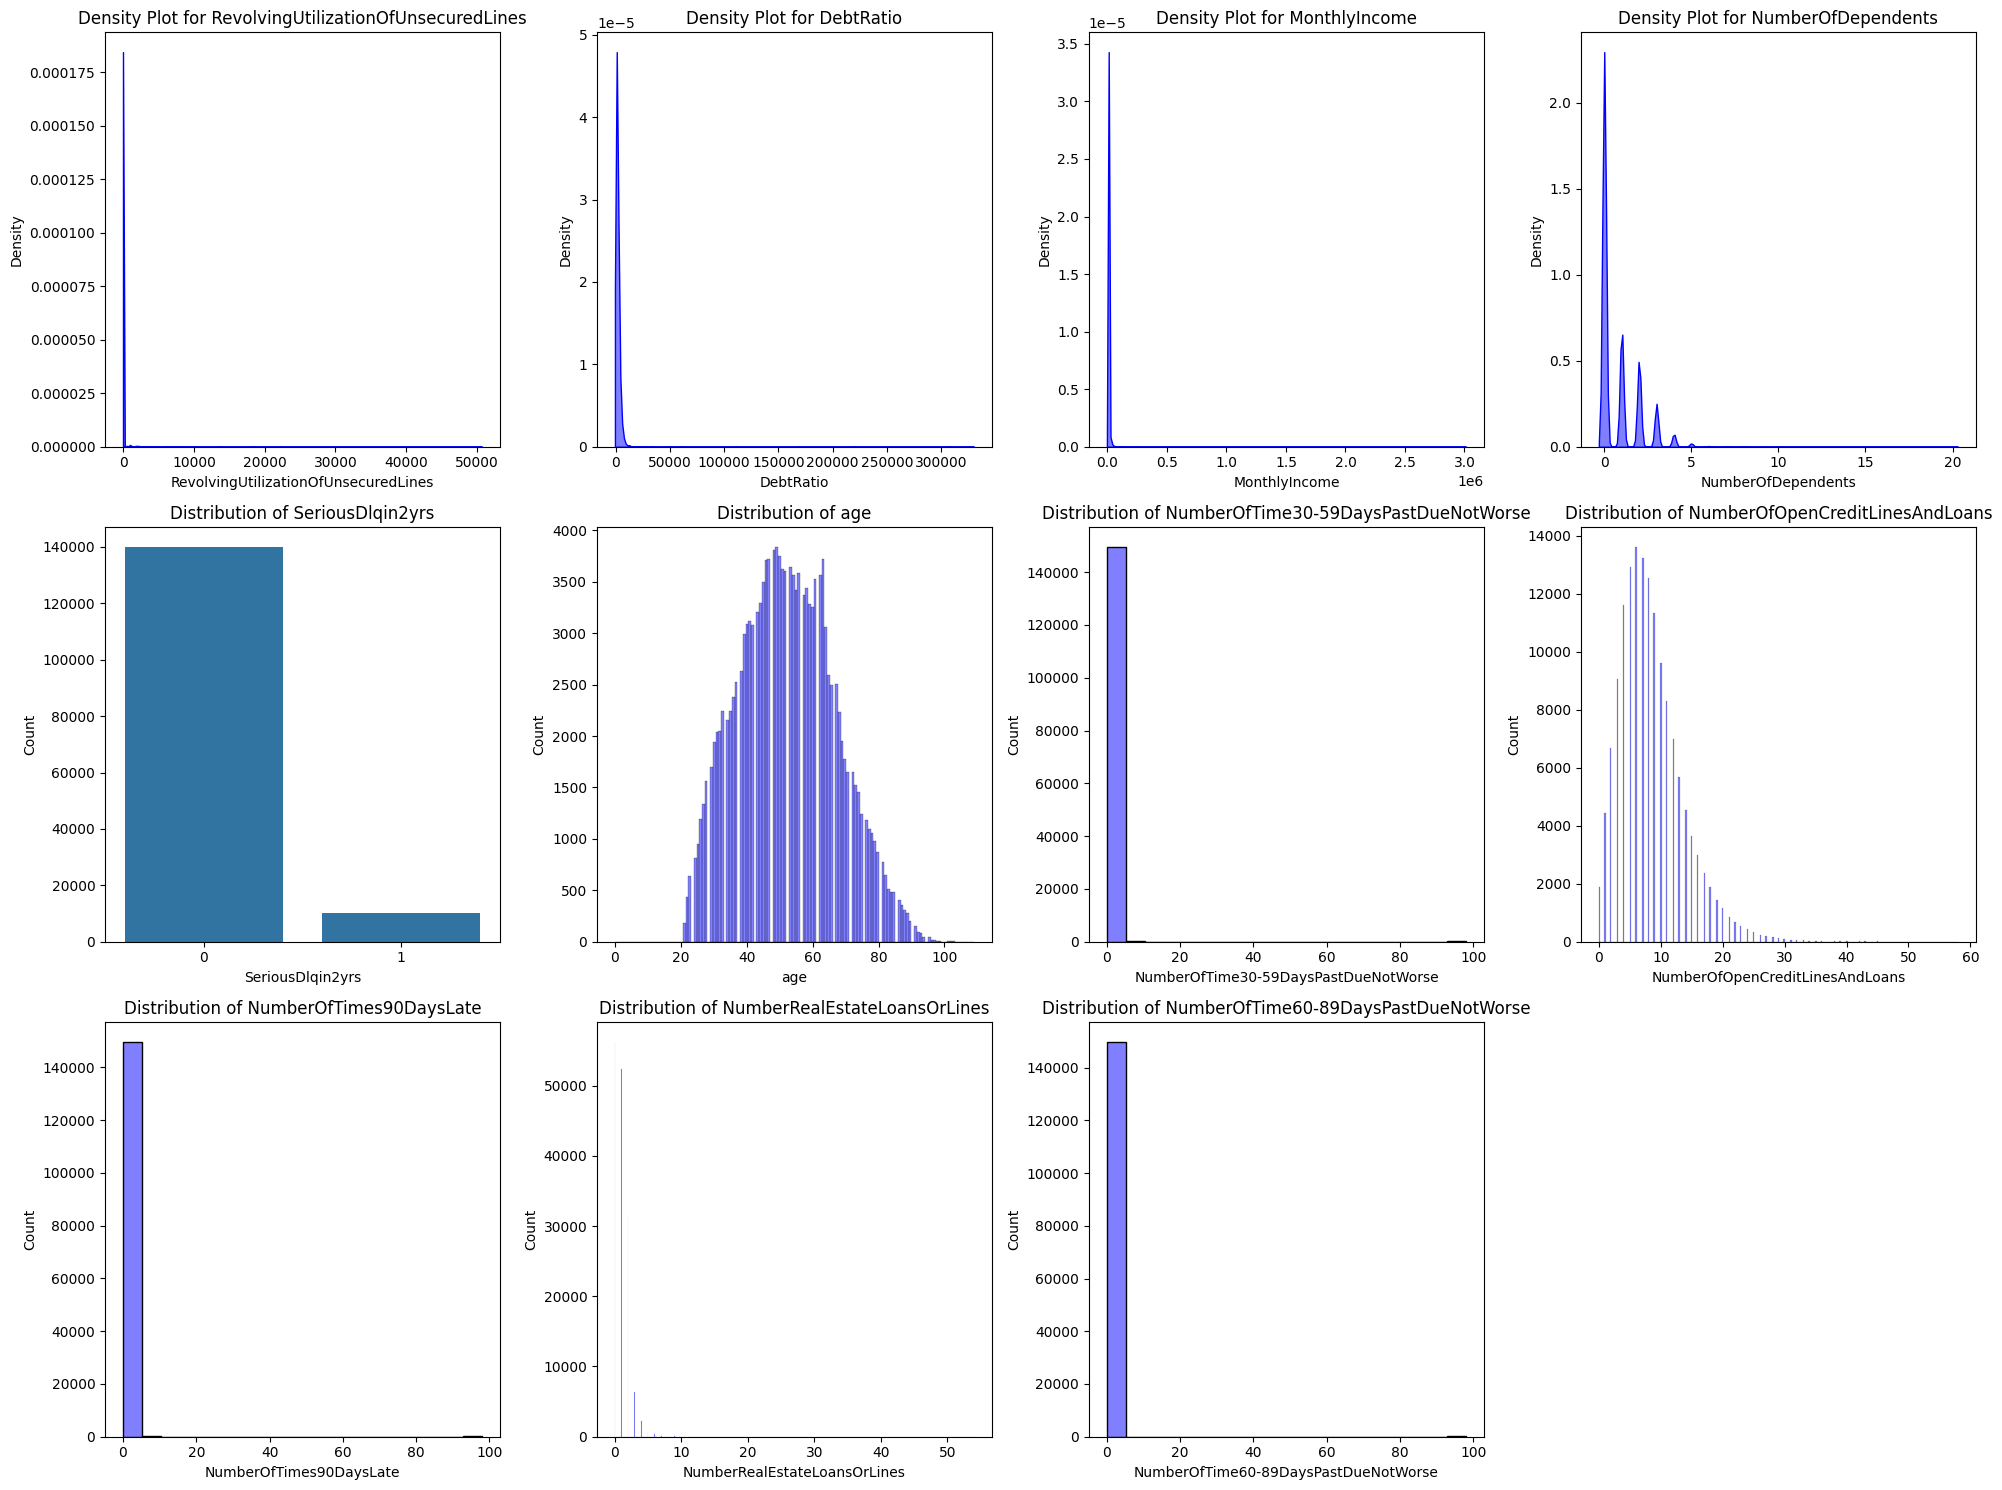

In [ ]:
# Split continuos and discrete variables
numerical_continuous = raw_data.select_dtypes(include=['float'])
numerical_discrete = raw_data.select_dtypes(include=['int'])

# config grid
plt.figure(figsize=(20, 15))
gs = plt.GridSpec(3, 4)

# Plot density
for i, column in enumerate(numerical_continuous.columns[:4]):
    ax = plt.subplot(gs[0, i])
    sns.kdeplot(data=numerical_continuous[column], fill=True, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Density Plot for {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

# Plot histogram
for i, column in enumerate(numerical_discrete.columns[:4]):
    ax = plt.subplot(gs[1, i])
    if len(numerical_discrete[column].unique()) <= 10:
        # Bar plot if less then 10 levels
        sns.countplot(data=numerical_discrete, x=column, ax=ax)
    else:
        # Hist if more then 10
        sns.histplot(data=numerical_discrete[column], kde=False, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Plot histogram or barplot
for i, column in enumerate(numerical_discrete.columns[4:]):
    ax = plt.subplot(gs[2, i])
    if len(numerical_discrete[column].unique()) <= 10:
        # Bar plot if less then 10 levels
        sns.countplot(data=numerical_discrete, x=column, ax=ax)
    else:
        # Hist if more then 10
        sns.histplot(data=numerical_discrete[column], kde=False, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Remove empty space
plt.subplot(gs[2, 3]).set_visible(False)

plt.tight_layout()
plt.show()

#### Using Z-score method to handling Outliers

In [ ]:
# Select variables target and age (good distribution)
predictors = raw_data.drop(columns=['SeriousDlqin2yrs', 'age'])

# Calculate z-score
z_scores = np.abs((predictors - predictors.mean()) / predictors.std())

# Z-score thershold
z_score_limit = 4.0

# Count number of observations more than 4.0
observations_to_remove = (z_scores > z_score_limit).sum()
print("Number of observations to me removed:")
print(observations_to_remove)

Number of observations to me removed:
RevolvingUtilizationOfUnsecuredLines    172
NumberOfTime30-59DaysPastDueNotWorse    269
DebtRatio                               282
MonthlyIncome                           193
NumberOfOpenCreditLinesAndLoans         442
NumberOfTimes90DaysLate                 270
NumberRealEstateLoansOrLines            793
NumberOfTime60-89DaysPastDueNotWorse    269
NumberOfDependents                      245
dtype: int64


In [ ]:
# Create boolean mask
mask_to_remove = (z_scores > z_score_limit).any(axis=1)
# New df
removed_outliers = raw_data[~mask_to_remove]

#### After handling outliers

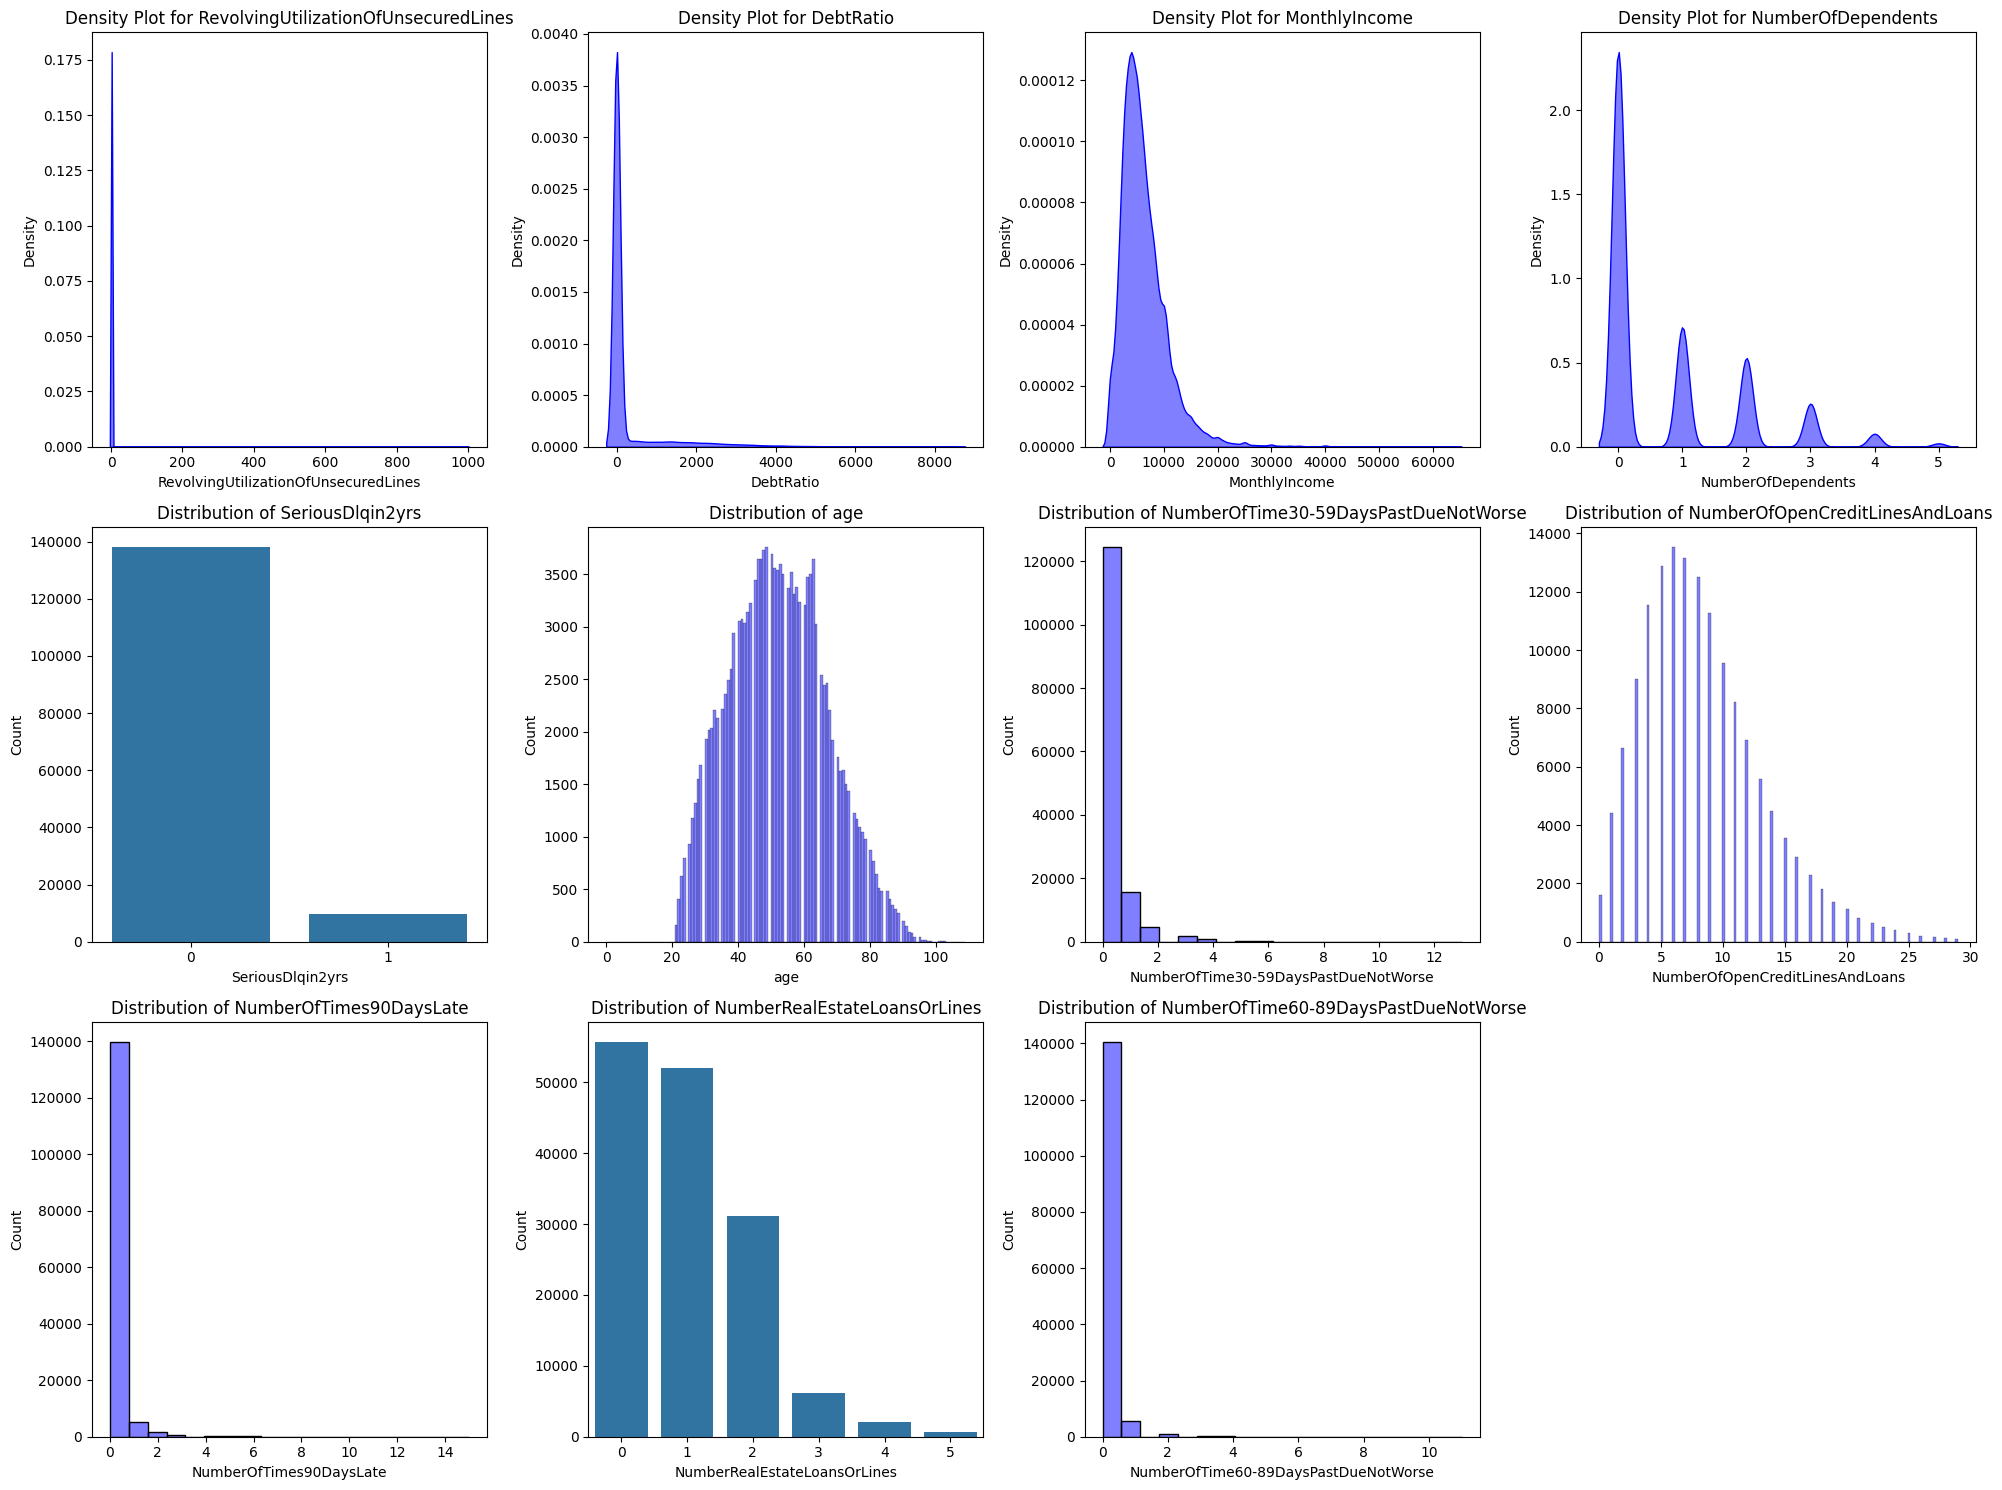

In [ ]:
# Same plot as before
numerical_continuous = removed_outliers.select_dtypes(include=['float'])
numerical_discrete = removed_outliers.select_dtypes(include=['int'])

plt.figure(figsize=(20, 15))
gs = plt.GridSpec(3, 4)

for i, column in enumerate(numerical_continuous.columns[:4]):
    ax = plt.subplot(gs[0, i])
    sns.kdeplot(data=numerical_continuous[column], fill=True, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Density Plot for {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

for i, column in enumerate(numerical_discrete.columns[:4]):
    ax = plt.subplot(gs[1, i])
    if len(numerical_discrete[column].unique()) <= 10:
        sns.countplot(data=numerical_discrete, x=column, ax=ax)
    else:
        sns.histplot(data=numerical_discrete[column], kde=False, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

for i, column in enumerate(numerical_discrete.columns[4:]):
    ax = plt.subplot(gs[2, i])
    if len(numerical_discrete[column].unique()) <= 10:
        sns.countplot(data=numerical_discrete, x=column, ax=ax)
    else:
        sns.histplot(data=numerical_discrete[column], kde=False, color='blue', alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

plt.subplot(gs[2, 3]).set_visible(False)
plt.tight_layout()
plt.show()

#### Analysis RUUL

[[0, np.float64(0.06524064171122995)], [1, np.float64(0.38752783964365256)], [2, np.float64(0.21717171717171718)], [3, np.float64(0.15126050420168066)], [4, np.float64(0.13043478260869565)], [5, np.float64(0.12195121951219512)], [6, np.float64(0.12)], [7, np.float64(0.125)], [8, np.float64(0.11267605633802817)], [9, np.float64(0.10144927536231885)], [10, np.float64(0.10144927536231885)], [11, np.float64(0.10144927536231885)], [12, np.float64(0.08823529411764706)], [13, np.float64(0.06060606060606061)], [14, np.float64(0.06060606060606061)], [15, np.float64(0.047619047619047616)], [16, np.float64(0.047619047619047616)], [17, np.float64(0.047619047619047616)], [18, np.float64(0.047619047619047616)], [19, np.float64(0.04838709677419355)]]


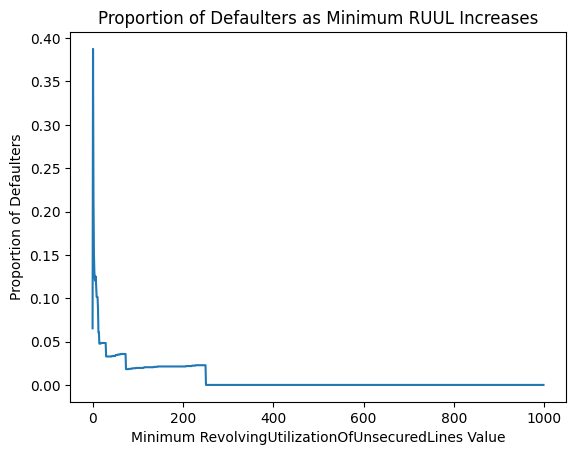

In [ ]:
default_prop_revolving = []
for i in range(int(removed_outliers["RevolvingUtilizationOfUnsecuredLines"].max())):
    temp_ = removed_outliers.loc[removed_outliers["RevolvingUtilizationOfUnsecuredLines"] >= i]
    default_prop_revolving.append([i, temp_["SeriousDlqin2yrs"].mean()])

print(default_prop_revolving[:20])
# Plot the line graph
sns.lineplot(x=[i[0] for i in default_prop_revolving], y=[i[1] for i in default_prop_revolving])

# Add the legends
plt.title("Proportion of Defaulters as Minimum RUUL Increases")
plt.xlabel("Minimum RevolvingUtilizationOfUnsecuredLines Value")
plt.ylabel("Proportion of Defaulters")
plt.show()


The variable "RevolvingUtilizationOfUnsecuredLines" represents the proportion of available credit that the customer is using. In other words, it indicates the amount of credit the customer uses in relation to the total credit available to him. When this proportion increases, the customer uses more of the available credit, which may indicate greater indebtedness. In this context, it is expected that, as the customer becomes more indebted, their ability to pay debts may also be compromised, leading to a greater risk of default. Therefore, when observing the distribution of "RevolvingUtilizationOfUnsecuredLines" in relation to the proportion of "SeriousDlqin2yrs", it is noted that when reaching the value of 13 for "RevolvingUtilizationOfUnsecuredLines", the proportion of "SeriousDlqin2yrs" decreases, indicating that the removal of observations above of this value must be removed from the dataset.

In [ ]:
removed_outliers_RUUL = removed_outliers[removed_outliers['RevolvingUtilizationOfUnsecuredLines'] < 13]

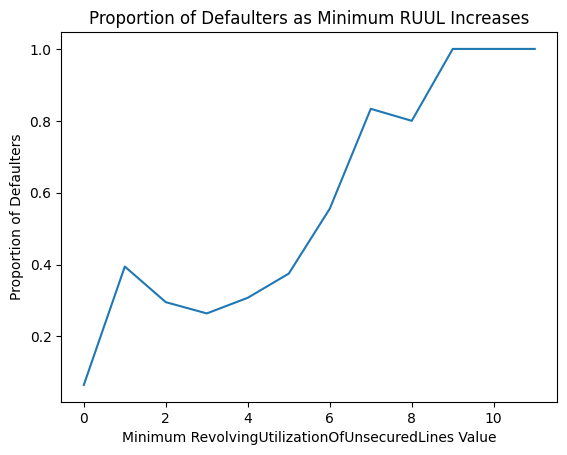

In [ ]:
default_prop_revolving = []
for i in range(int(removed_outliers_RUUL["RevolvingUtilizationOfUnsecuredLines"].max())):
    temp_ = removed_outliers_RUUL.loc[removed_outliers_RUUL["RevolvingUtilizationOfUnsecuredLines"] >= i]
    default_prop_revolving.append([i, temp_["SeriousDlqin2yrs"].mean()])
# Plot the line graph
sns.lineplot(x=[i[0] for i in default_prop_revolving], y=[i[1] for i in default_prop_revolving])

# Add the legends
plt.title("Proportion of Defaulters as Minimum RUUL Increases")
plt.xlabel("Minimum RevolvingUtilizationOfUnsecuredLines Value")
plt.ylabel("Proportion of Defaulters")
plt.show()

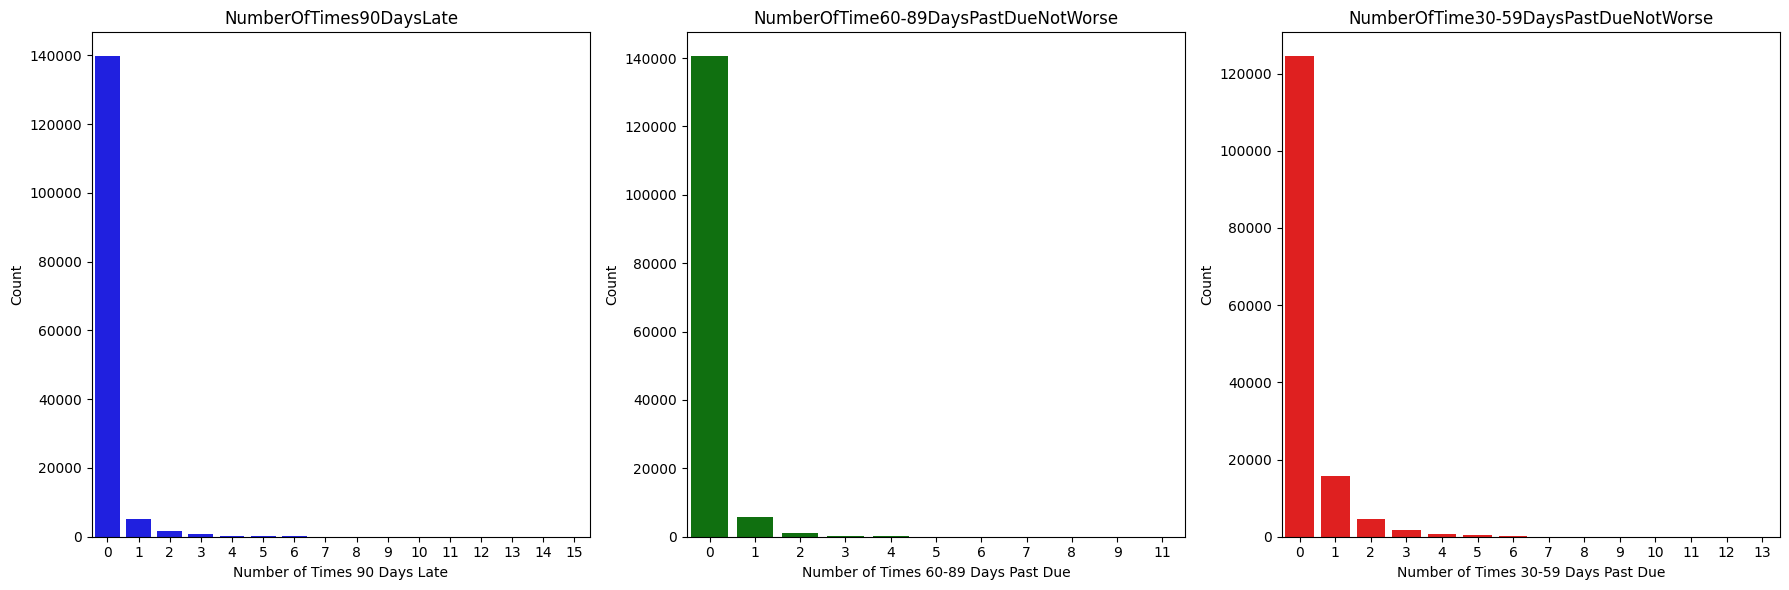

In [ ]:
# Grid config
plt.figure(figsize=(18, 6))
gs = plt.GridSpec(1, 3)

# Plot count for NumberOfTimes90DaysLate
ax1 = plt.subplot(gs[0, 0])
sns.countplot(data=removed_outliers, x='NumberOfTimes90DaysLate', color='blue')
plt.title('NumberOfTimes90DaysLate')
plt.xlabel('Number of Times 90 Days Late')
plt.ylabel('Count')

# Plot count for NumberOfTime60-89DaysPastDueNotWorse
ax2 = plt.subplot(gs[0, 1])
sns.countplot(data=removed_outliers, x='NumberOfTime60-89DaysPastDueNotWorse', color='green')
plt.title('NumberOfTime60-89DaysPastDueNotWorse')
plt.xlabel('Number of Times 60-89 Days Past Due')
plt.ylabel('Count')

# Plot count for NumberOfTime30-59DaysPastDueNotWorse
ax3 = plt.subplot(gs[0, 2])
sns.countplot(data=removed_outliers, x='NumberOfTime30-59DaysPastDueNotWorse', color='red')
plt.title('NumberOfTime30-59DaysPastDueNotWorse')
plt.xlabel('Number of Times 30-59 Days Past Due')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

After Outlier removal

NumberOfTimes90DaysLate No no one who is 90 or more days past due 15.

NumberOfTime60-89DaysPastDueNotWorse No no one who is 90 or more days past due 11.

NumberOfTime30-59DaysPastDueNotWorse No no one who is 90 or more days past due 13.

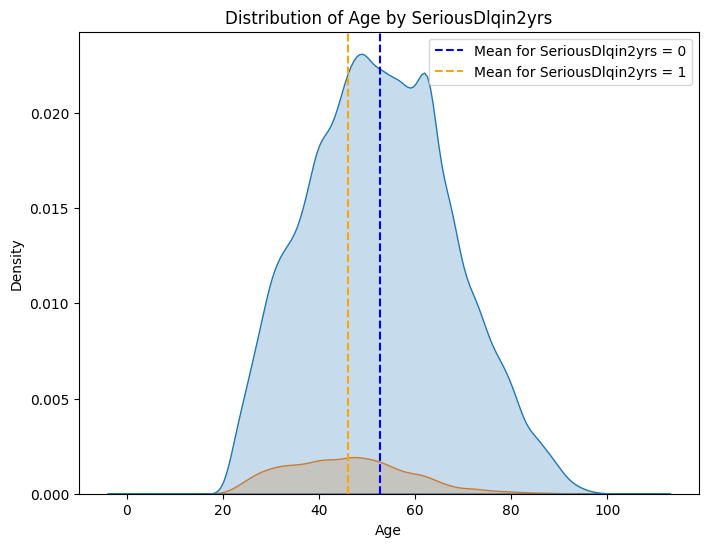

In [ ]:
# Calculate the mean for each class of SeriousDlqin2yrs
mean_0 = removed_outliers_RUUL.loc[removed_outliers_RUUL['SeriousDlqin2yrs'] == 0, 'age'].mean()
mean_1 = removed_outliers_RUUL.loc[removed_outliers_RUUL['SeriousDlqin2yrs'] == 1, 'age'].mean()

plt.figure(figsize=(8, 6))
sns.kdeplot(data=removed_outliers_RUUL, x='age', hue='SeriousDlqin2yrs', fill=True)
plt.axvline(mean_0, linestyle='--', color='blue', label='Mean for SeriousDlqin2yrs = 0')
plt.axvline(mean_1, linestyle='--', color='orange', label='Mean for SeriousDlqin2yrs = 1')
plt.title('Distribution of Age by SeriousDlqin2yrs')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

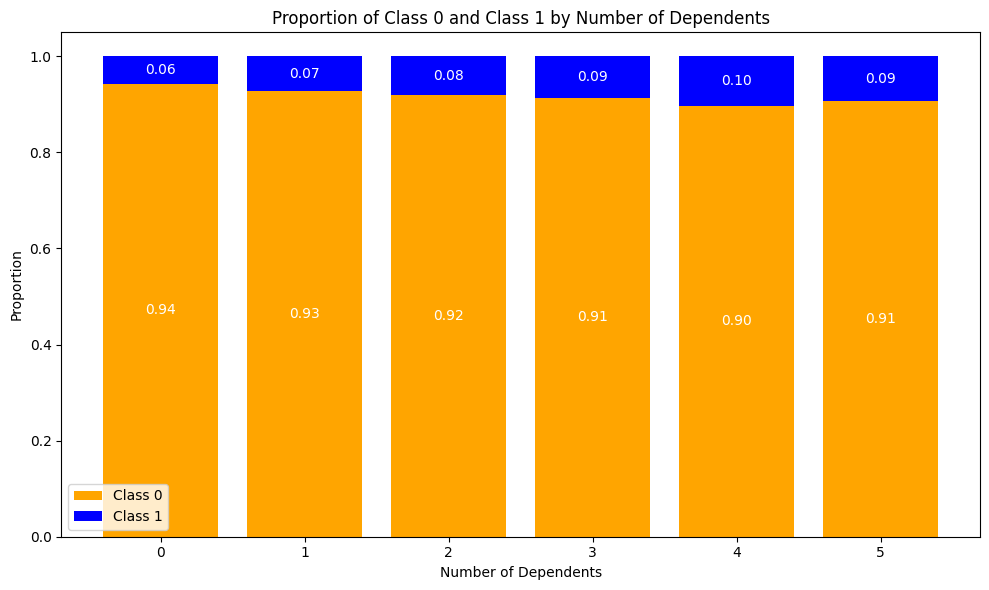

In [ ]:
# Calculate proportion of default by 'NumberOfDependets'
prop_df = removed_outliers_RUUL.groupby(['NumberOfDependents', 'SeriousDlqin2yrs']).size().unstack()
prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)  # Dividir pelo total de cada linha para obter as proporções

# Plot bar plot
plt.figure(figsize=(10, 6))

# Set colors
colors = ['orange', 'blue']

# Plot bars for each class
for i in range(len(prop_df.columns)):
    plt.bar(prop_df.index, prop_df[prop_df.columns[i]], bottom=prop_df.iloc[:, :i].sum(axis=1), label=f'Class {prop_df.columns[i]}', color=colors[i])

# Add proportion value
for i in range(len(prop_df)):
    for j in range(len(prop_df.columns)):
        value = prop_df.iloc[i, j]
        plt.text(i, prop_df.iloc[:, :j].sum(axis=1)[i] + value / 2, f'{value:.2f}', ha='center', va='center', color='white', fontsize=10)

plt.xlabel('Number of Dependents')
plt.ylabel('Proportion')
plt.title('Proportion of Class 0 and Class 1 by Number of Dependents')
plt.legend()
plt.tight_layout()
plt.show()

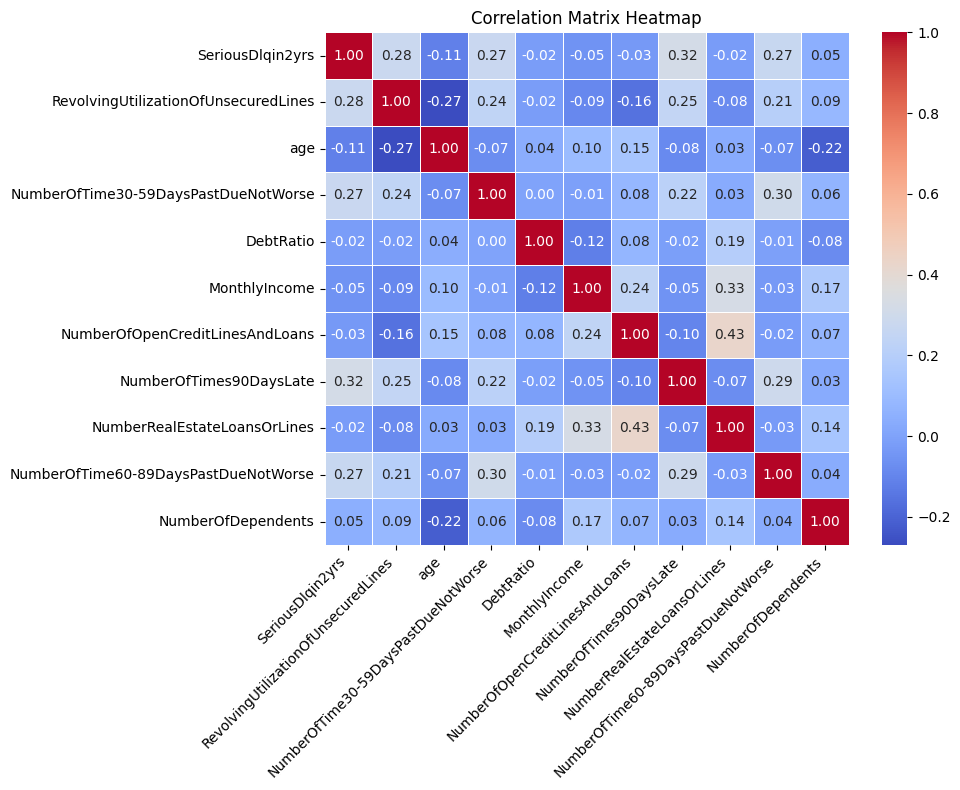

In [ ]:
# Calculate the correlation matrix
corr_matrix = removed_outliers_RUUL.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

###2.2 Handling missing values

                Column  Missing Values  Missing Values (%)
5        MonthlyIncome           29180           19.761079
10  NumberOfDependents            3861            2.614720


<ipython-input-19-82ebd72cd95f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Column', y='Missing Values (%)', data=missing_values_filter, palette="viridis")


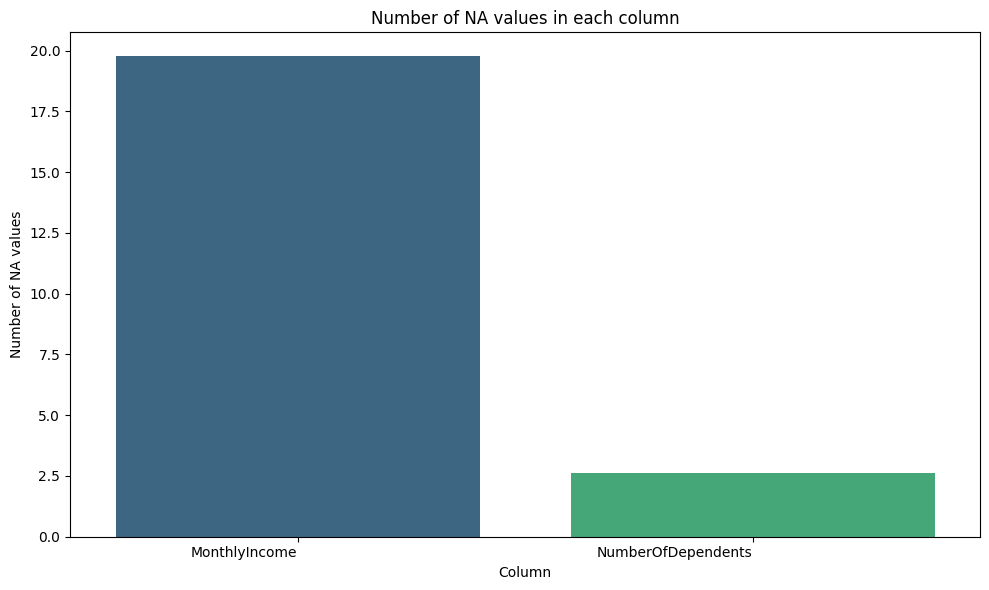

In [ ]:
# Counting the number of NA values per column
na_counts = removed_outliers_RUUL.isna().sum()

# Show percent
missing_values_percent = (na_counts / len(removed_outliers_RUUL)) * 100
missing_values = pd.DataFrame({'Column': na_counts.index, 'Missing Values': na_counts.values, 'Missing Values (%)': missing_values_percent.values})

# Filter and print rows with missing values greater than 0
print(missing_values[missing_values['Missing Values'] > 0])

missing_values_filter = missing_values[missing_values['Missing Values'] > 0]
missing_values_filter = missing_values_filter.sort_values(by='Missing Values (%)', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Column', y='Missing Values (%)', data=missing_values_filter, palette="viridis")
plt.ylabel('Number of NA values')
plt.title('Number of NA values in each column')
plt.xticks(rotation=0, ha="right")
plt.tight_layout()
plt.show()

#### Imputation

In [ ]:
# Imputation by Mean
imputed_df_mean = removed_outliers_RUUL.copy()

mean_imputer = SimpleImputer(strategy='mean')
imputed_df_mean['MonthlyIncome'] = mean_imputer.fit_transform(imputed_df_mean[['MonthlyIncome']])
imputed_df_mean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147664 entries, 2 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      147664 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  147664 non-null  float64
 2   age                                   147664 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  147664 non-null  int64  
 4   DebtRatio                             147664 non-null  float64
 5   MonthlyIncome                         147664 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       147664 non-null  int64  
 7   NumberOfTimes90DaysLate               147664 non-null  int64  
 8   NumberRealEstateLoansOrLines          147664 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  147664 non-null  int64  
 10  NumberOfDependents                    143803 non-null  float64
dtypes: fl

In [ ]:
# MICE imputation
df_copy = removed_outliers_RUUL.copy()
missing_values = df_copy.isna()
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_values = imputer.fit_transform(df_copy.values)
imputed_df_mice = pd.DataFrame(imputed_values, columns=df_copy.columns)

#### After handling missing values

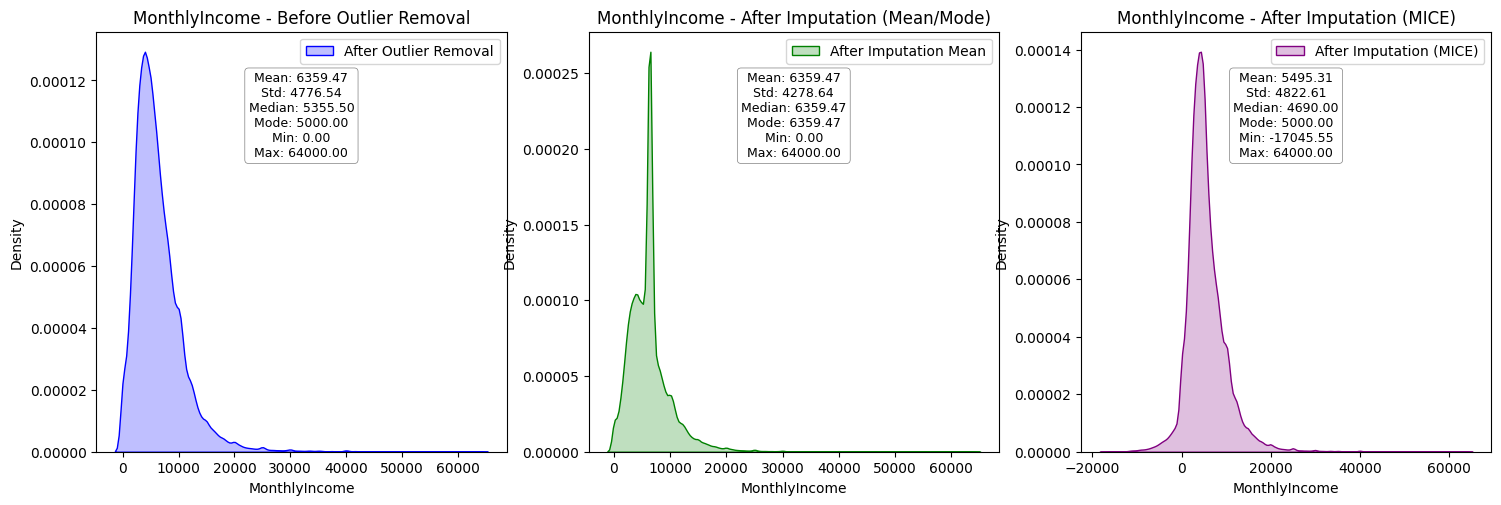

In [ ]:
plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

# Plot without imputation - after outlier removal
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(data=removed_outliers_RUUL, x='MonthlyIncome', fill=True, color='blue', label='After Outlier Removal')
add_stats_to_plot(removed_outliers_RUUL, 'MonthlyIncome', ax1)
plt.title('MonthlyIncome - Before Outlier Removal')
plt.xlabel('MonthlyIncome')
plt.ylabel('Density')
plt.legend()

# Imputation by mean plot
ax2 = plt.subplot(gs[0, 1])
sns.kdeplot(data=imputed_df_mean, x='MonthlyIncome', fill=True, color='green', label='After Imputation Mean')
add_stats_to_plot(imputed_df_mean, 'MonthlyIncome', ax2)
plt.title('MonthlyIncome - After Imputation (Mean/Mode)')
plt.xlabel('MonthlyIncome')
plt.ylabel('Density')
plt.legend()

# MICE
ax3 = plt.subplot(gs[0, 2])
sns.kdeplot(data=imputed_df_mice, x='MonthlyIncome', fill=True, color='purple', label='After Imputation (MICE)')
add_stats_to_plot(imputed_df_mice, 'MonthlyIncome', ax3)
plt.title('MonthlyIncome - After Imputation (MICE)')
plt.xlabel('MonthlyIncome')
plt.ylabel('Density')
plt.legend()

###2.3 Handling duplicated rows

In [ ]:
# Verify duplicated rows
duplicated_rows = imputed_df_mice.duplicated()
duplicated_data = imputed_df_mice[duplicated_rows]
duplicated_data.count()

,0
SeriousDlqin2yrs,565
RevolvingUtilizationOfUnsecuredLines,565
age,565
NumberOfTime30-59DaysPastDueNotWorse,565
DebtRatio,565
MonthlyIncome,565
NumberOfOpenCreditLinesAndLoans,565
NumberOfTimes90DaysLate,565
NumberRealEstateLoansOrLines,565
NumberOfTime60-89DaysPastDueNotWorse,565


In [ ]:
# Remove duplicates
df_final = imputed_df_mice.drop_duplicates()

###2.4 Analysis target variables

In [ ]:
print("\nAnalysis target variable 'SeriousDlqin2yrs':")
target_counts = df_final['SeriousDlqin2yrs'].value_counts()
target_percentage = df_final['SeriousDlqin2yrs'].value_counts(normalize=True) * 100
print("Number:\n", target_counts)
print("\nPercent:\n", target_percentage)


Analysis target variable 'SeriousDlqin2yrs':
Number:
 SeriousDlqin2yrs
0.0    137471
1.0      9628
Name: count, dtype: int64

Percent:
 SeriousDlqin2yrs
0.0    93.454748
1.0     6.545252
Name: proportion, dtype: float64


<ipython-input-26-179a16d005d8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='SeriousDlqin2yrs', palette="viridis")


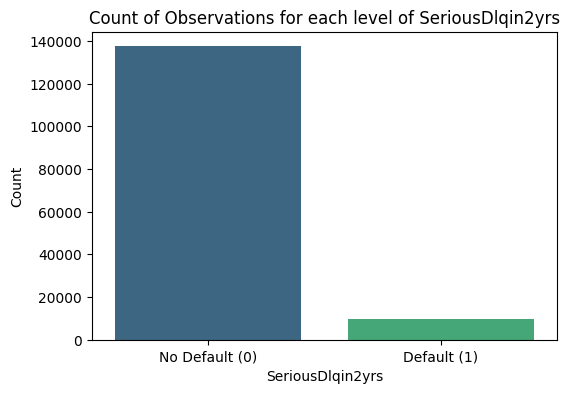

In [ ]:
# Plot levels of target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=df_final, x='SeriousDlqin2yrs', palette="viridis")
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Count')
plt.title('Count of Observations for each level of SeriousDlqin2yrs')
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.show()

###2.5 Split Dataset

In [ ]:
X = df_final.drop('SeriousDlqin2yrs', axis=1)
y = df_final['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 3. Modeling & Training Model

In [ ]:
#Over sampling
# SMOTE - to deal with the imbalanced response variable
smote = SMOTE(sampling_strategy="auto")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
#Under Sampling
#Thử Undersampling
undersample = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
#Thử Nmiss
nm3 = NearMiss(version=3, n_neighbors_ver3=3) # Bạn có thể thử các giá trị khác cho n_neighbors_ver3
X_train_nm3, y_train_nm3 = nm3.fit_resample(X_train, y_train)


--- Đánh giá các mô hình với dữ liệu GỐC (Mất cân bằng) ---

*** Đang huấn luyện và đánh giá: Random Forest (Dữ liệu gốc) ***

Đánh giá chi tiết Random Forest trên tập Test (Dữ liệu gốc):
Classification Report:
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.94      0.99      0.97     41215
      Vỡ nợ (1)       0.55      0.18      0.28      2915

       accuracy                           0.94     44130
      macro avg       0.75      0.59      0.62     44130
   weighted avg       0.92      0.94      0.92     44130

Confusion Matrix:
[[40782   433]
 [ 2380   535]]


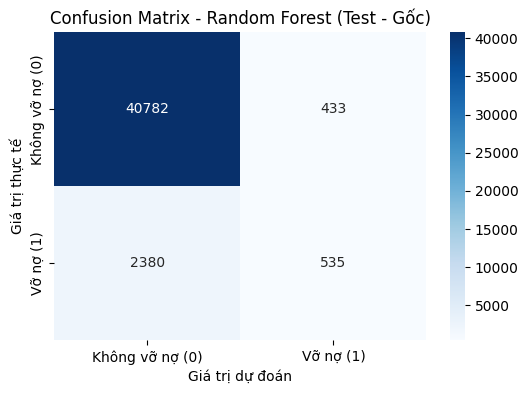


*** Đang huấn luyện và đánh giá: LOG Reg (Dữ liệu gốc) ***


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Đánh giá chi tiết LOG Reg trên tập Test (Dữ liệu gốc):
Classification Report:
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.94      0.99      0.97     41215
      Vỡ nợ (1)       0.59      0.17      0.26      2915

       accuracy                           0.94     44130
      macro avg       0.77      0.58      0.61     44130
   weighted avg       0.92      0.94      0.92     44130

Confusion Matrix:
[[40883   332]
 [ 2431   484]]


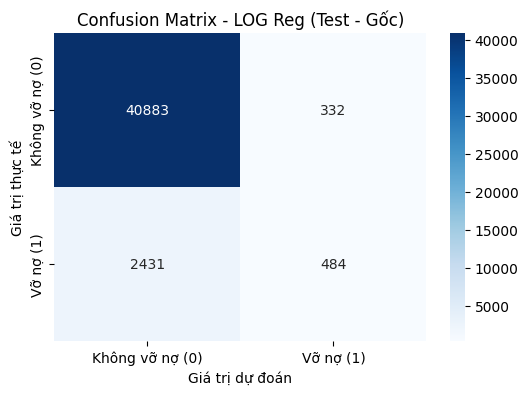


*** Đang huấn luyện và đánh giá: XGBoost (Dữ liệu gốc) ***


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:53:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Đánh giá chi tiết XGBoost trên tập Test (Dữ liệu gốc):
Classification Report:
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.95      0.99      0.97     41215
      Vỡ nợ (1)       0.59      0.23      0.33      2915

       accuracy                           0.94     44130
      macro avg       0.77      0.61      0.65     44130
   weighted avg       0.92      0.94      0.93     44130

Confusion Matrix:
[[40753   462]
 [ 2251   664]]


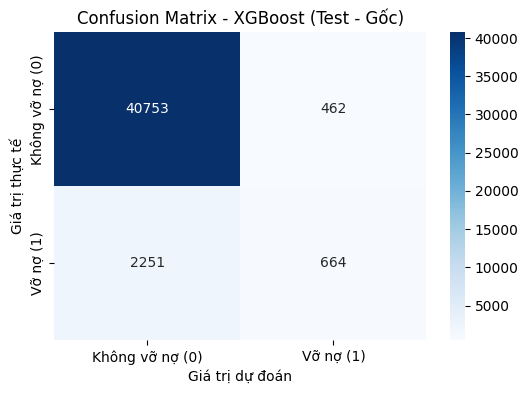


*** Đang huấn luyện và đánh giá: LGBoost (Dữ liệu gốc) ***
[LightGBM] [Info] Number of positive: 6713, number of negative: 96256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 102969, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065194 -> initscore=-2.662965
[LightGBM] [Info] Start training from score -2.662965

Đánh giá chi tiết LGBoost trên tập Test (Dữ liệu gốc):
Classification Report:
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.95      0.99      0.97     41215
      Vỡ nợ (1)       0.62      0.19      0.29      2915

       accuracy                           0.94     44130
      macro avg       0.78      0.59      0.63     44130
   weighted avg       0.92      0.94      0.92     44130

Confusion Matrix:
[[40

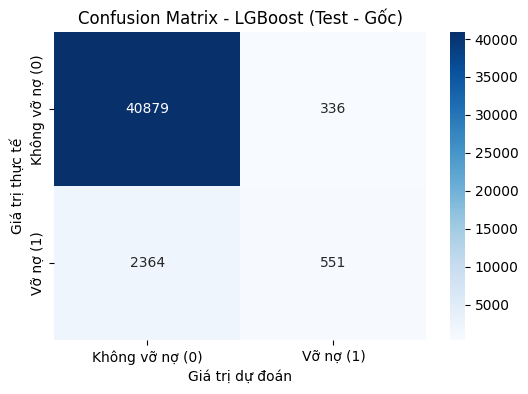



--- Đánh giá các mô hình với dữ liệu SMOTE ---

*** Đang huấn luyện và đánh giá: Random Forest (Dữ liệu SMOTE) ***

Đánh giá chi tiết Random Forest (Huấn luyện SMOTE) trên tập Test:
Classification Report:
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.98      0.78      0.87     41215
      Vỡ nợ (1)       0.19      0.76      0.31      2915

       accuracy                           0.77     44130
      macro avg       0.59      0.77      0.59     44130
   weighted avg       0.93      0.77      0.83     44130

Confusion Matrix:
[[31975  9240]
 [  702  2213]]


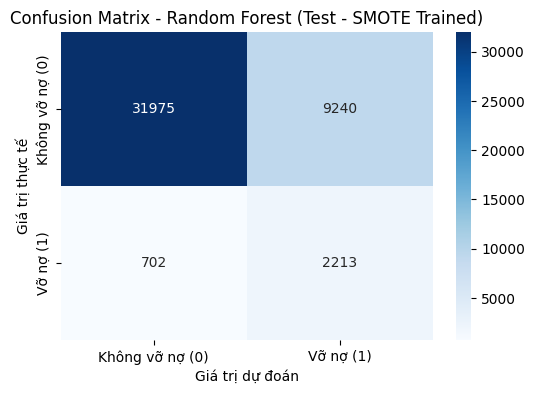


*** Đang huấn luyện và đánh giá: LOG Reg (Dữ liệu SMOTE) ***


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Đánh giá chi tiết LOG Reg (Huấn luyện SMOTE) trên tập Test:
Classification Report:
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.98      0.82      0.89     41215
      Vỡ nợ (1)       0.22      0.72      0.34      2915

       accuracy                           0.81     44130
      macro avg       0.60      0.77      0.61     44130
   weighted avg       0.93      0.81      0.85     44130

Confusion Matrix:
[[33767  7448]
 [  802  2113]]


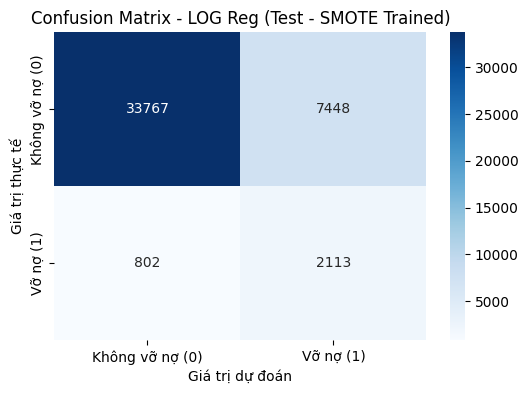


*** Đang huấn luyện và đánh giá: XGBoost (Dữ liệu SMOTE) ***


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:53:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Đánh giá chi tiết XGBoost (Huấn luyện SMOTE) trên tập Test:
Classification Report:
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.98      0.75      0.85     41215
      Vỡ nợ (1)       0.18      0.77      0.29      2915

       accuracy                           0.75     44130
      macro avg       0.58      0.76      0.57     44130
   weighted avg       0.93      0.75      0.81     44130

Confusion Matrix:
[[31015 10200]
 [  656  2259]]


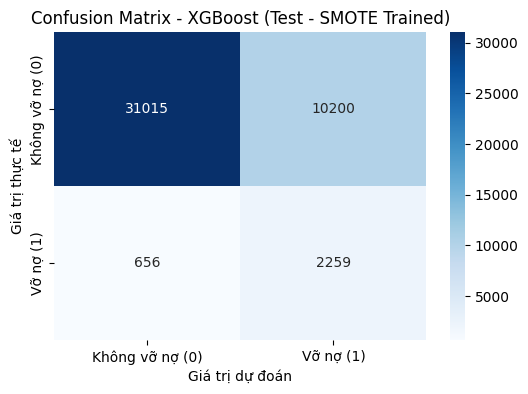


*** Đang huấn luyện và đánh giá: LGBoost (Dữ liệu SMOTE) ***
[LightGBM] [Info] Number of positive: 6713, number of negative: 6713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 13426, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Đánh giá chi tiết LGBoost (Huấn luyện SMOTE) trên tập Test:
Classification Report:
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.98      0.77      0.86     41215
      Vỡ nợ (1)       0.19      0.78      0.31      2915

       accuracy                           0.77     44130
      macro avg       0.58      0.77      0.58     44130
   weighted avg       0.93      0.77      0.82     44130

Confusion Matrix:
[[31572  9643]
 [  651  2264]]


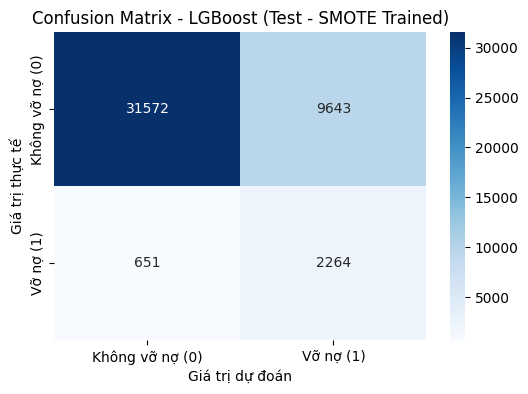


--- Bảng tóm tắt kết quả trên tập Test ---
           Model               Data    Recall  Precision       AUC  F1-Score
0  Random Forest  Unbalanced - Test  0.936257   0.918954  0.843521  0.921011
1        LOG Reg  Unbalanced - Test  0.937390   0.920707  0.854526  0.920555
2        XGBoost  Unbalanced - Test  0.938523   0.924011  0.862957  0.925567
3        LGBoost  Unbalanced - Test  0.938817   0.923921  0.868929  0.923234
4  Random Forest       SMOTE - Test  0.759177   0.193224  0.842083  0.308046
5        LOG Reg       SMOTE - Test  0.724871   0.221002  0.850060  0.338730
6        XGBoost       SMOTE - Test  0.774957   0.181315  0.840338  0.293873
7        LGBoost       SMOTE - Test  0.776672   0.190140  0.848701  0.305492


In [ ]:
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, X_train_nm3, y_train_nm3)

Đang chạy GridSearchCV để tìm siêu tham số tốt nhất (tối ưu F1 lớp 1)...

--- Thông tin Mô hình Logistic Regression Tốt nhất (Sau GridSearchCV - Dữ liệu gốc) ---
Siêu tham số tốt nhất: {'C': 10, 'solver': 'liblinear'}
Điểm F1-score lớp 1 tốt nhất trên validation (CV): 0.2503

--- 1. Đánh giá trên tập Test với Ngưỡng Mặc định (0.5) ---

Đánh giá chi tiết trên tập Test (Ngưỡng mặc định 0.5):
Classification Report (Ngưỡng mặc định 0.5):
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.94      0.99      0.97     41215
      Vỡ nợ (1)       0.61      0.16      0.26      2915

       accuracy                           0.94     44130
      macro avg       0.78      0.58      0.61     44130
   weighted avg       0.92      0.94      0.92     44130


Confusion Matrix (Ngưỡng mặc định 0.5):
[[40906   309]
 [ 2438   477]]


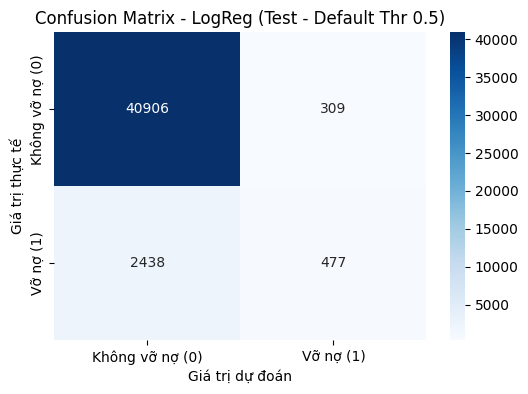


Metrics với ngưỡng mặc định 0.5:
  AUC: 0.8255
  F1-Score Lớp 1: 0.2578
  Recall Lớp 1: 0.1636
  Precision Lớp 1: 0.6069

--- 2. Tìm Ngưỡng Tối ưu cho F1 Lớp 1 (sử dụng tập Test làm Validation) ---
Ngưỡng tối ưu (cho F1 lớp 1): 0.2097
F1-score tốt nhất cho lớp 1 tại ngưỡng này: 0.4008


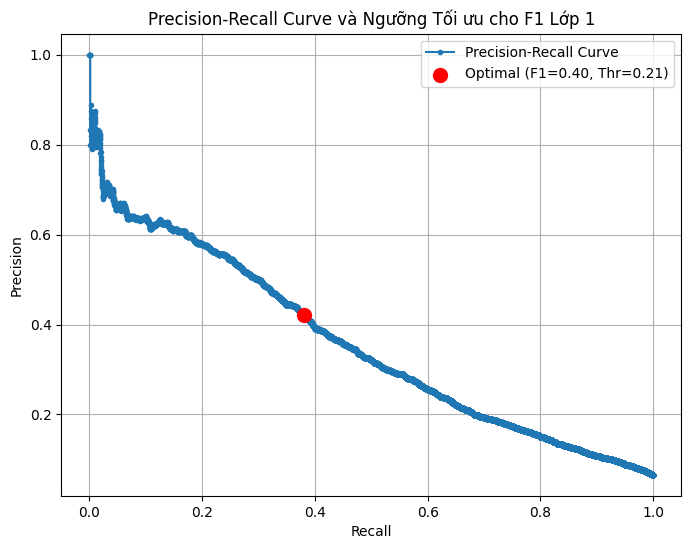


--- 3. Đánh giá lại trên tập Test với Ngưỡng Tối ưu = 0.2097 ---

Đánh giá chi tiết trên tập Test (Ngưỡng tối ưu):
Classification Report (Ngưỡng tối ưu):
                 precision    recall  f1-score   support

Không vỡ nợ (0)       0.96      0.96      0.96     41215
      Vỡ nợ (1)       0.42      0.38      0.40      2915

       accuracy                           0.92     44130
      macro avg       0.69      0.67      0.68     44130
   weighted avg       0.92      0.92      0.92     44130


Confusion Matrix (Ngưỡng tối ưu):
[[39693  1522]
 [ 1803  1112]]


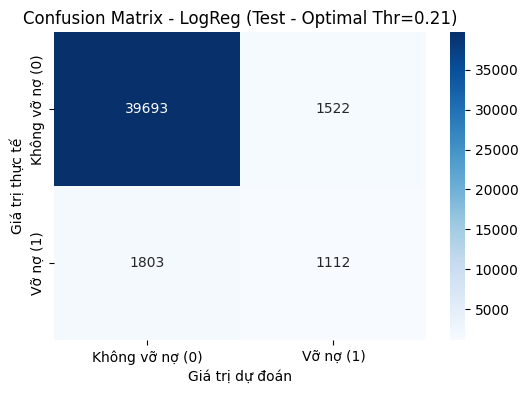


Metrics với ngưỡng tối ưu (0.2097):
  AUC: 0.8255
  F1-Score Lớp 1: 0.4008
  Recall Lớp 1: 0.3815
  Precision Lớp 1: 0.4222

Kết quả tóm tắt với ngưỡng tối ưu:
{'Model': 'LogReg Unbalanced (Optimal Thr)', 'Data': 'Test', 'Best_Params': {'C': 10, 'solver': 'liblinear'}, 'Optimal_Threshold': np.float64(0.209651944953658), 'AUC': np.float64(0.825543706817927), 'F1_1_Optimal': 0.40079293566408364, 'Recall_1_Optimal': 0.38147512864494, 'Precision_1_Optimal': 0.42217160212604404, 'Precision_0': 0.95655002891845, 'Recall_0': 0.9630716971976222, 'F1_0': 0.9597997847928329}


In [ ]:
# Definy model
logreg_model = LogisticRegression(max_iter=1000, penalty='l2', random_state=42) # Thêm random_state cho nhất quán

# What hiperparameters to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'] # Nên thêm class_weight nếu muốn thử nghiệm cả trường hợp đó
    # Ví dụ: 'class_weight': [None, 'balanced']
}

# StratifiedKfold
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scorer để tối ưu F1-score cho lớp 1 trong GridSearchCV
f1_label1_scorer = make_scorer(f1_score, pos_label=1)

# Grisearch
grid_search_unbalanced = GridSearchCV(estimator=logreg_model,
                                      param_grid=param_grid,
                                      scoring=f1_label1_scorer, # Tối ưu theo F1 lớp 1
                                      cv=cv_stratified,
                                      n_jobs=-1)

print("Đang chạy GridSearchCV để tìm siêu tham số tốt nhất (tối ưu F1 lớp 1)...")
grid_search_unbalanced.fit(X_train, y_train) # Huấn luyện trên X_train, y_train

best_unbalanced_model = grid_search_unbalanced.best_estimator_

print("\n--- Thông tin Mô hình Logistic Regression Tốt nhất (Sau GridSearchCV - Dữ liệu gốc) ---")
print(f"Siêu tham số tốt nhất: {grid_search_unbalanced.best_params_}")
print(f"Điểm F1-score lớp 1 tốt nhất trên validation (CV): {grid_search_unbalanced.best_score_:.4f}")


# --- BƯỚC 1: ĐÁNH GIÁ VỚI NGƯỠNG MẶC ĐỊNH (0.5) ---
print("\n--- 1. Đánh giá trên tập Test với Ngưỡng Mặc định (0.5) ---")
# Dự đoán với ngưỡng mặc định (0.5)
y_pred_test_default_threshold = best_unbalanced_model.predict(X_test)

print("\nĐánh giá chi tiết trên tập Test (Ngưỡng mặc định 0.5):")
print("Classification Report (Ngưỡng mặc định 0.5):")
print(classification_report(y_test, y_pred_test_default_threshold, target_names=class_labels))

print("\nConfusion Matrix (Ngưỡng mặc định 0.5):")
cm_test_default = confusion_matrix(y_test, y_pred_test_default_threshold)
print(cm_test_default)
plot_confusion_matrix_heatmap(cm_test_default, class_labels, 'Confusion Matrix - LogReg (Test - Default Thr 0.5)')

# Tính các metrics với ngưỡng mặc định (nếu bạn muốn so sánh)
f1_default_class1 = f1_score(y_test, y_pred_test_default_threshold, pos_label=1)
recall_default_class1 = recall_score(y_test, y_pred_test_default_threshold, pos_label=1)
precision_default_class1 = precision_score(y_test, y_pred_test_default_threshold, pos_label=1)
auc_default = roc_auc_score(y_test, best_unbalanced_model.predict_proba(X_test)[:, 1])
print(f"\nMetrics với ngưỡng mặc định 0.5:")
print(f"  AUC: {auc_default:.4f}")
print(f"  F1-Score Lớp 1: {f1_default_class1:.4f}")
print(f"  Recall Lớp 1: {recall_default_class1:.4f}")
print(f"  Precision Lớp 1: {precision_default_class1:.4f}")


# --- BƯỚC 2: TÌM NGƯỠNG TỐI ƯU TRÊN TẬP TEST (đóng vai trò validation) ---
print("\n--- 2. Tìm Ngưỡng Tối ưu cho F1 Lớp 1 (sử dụng tập Test làm Validation) ---")
# Sử dụng X_test, y_test để tìm ngưỡng.
# Nhắc lại: Trong thực tế, đây nên là một tập validation riêng biệt.
optimal_threshold_f1, best_f1_at_optimal_val = find_optimal_threshold_f1_label1(
    best_unbalanced_model,
    X_test, # Dùng X_test làm dữ liệu "validation" để tìm ngưỡng
    y_test  # Nhãn thực tế của X_test
)


# --- BƯỚC 3: ĐÁNH GIÁ LẠI VỚI NGƯỠNG TỐI ƯU ---
print(f"\n--- 3. Đánh giá lại trên tập Test với Ngưỡng Tối ưu = {optimal_threshold_f1:.4f} ---")

# Lấy xác suất dự đoán trên tập Test
y_pred_proba_test_for_optimal = best_unbalanced_model.predict_proba(X_test)[:, 1]

# Áp dụng ngưỡng mới để tạo dự đoán lớp
y_pred_test_optimal_threshold = (y_pred_proba_test_for_optimal >= optimal_threshold_f1).astype(int)

print("\nĐánh giá chi tiết trên tập Test (Ngưỡng tối ưu):")
print("Classification Report (Ngưỡng tối ưu):")
print(classification_report(y_test, y_pred_test_optimal_threshold, target_names=class_labels))

print("\nConfusion Matrix (Ngưỡng tối ưu):")
cm_test_optimal = confusion_matrix(y_test, y_pred_test_optimal_threshold)
print(cm_test_optimal)
plot_confusion_matrix_heatmap(cm_test_optimal, class_labels, f'Confusion Matrix - LogReg (Test - Optimal Thr={optimal_threshold_f1:.2f})')

# Tính toán lại các metrics quan trọng với ngưỡng tối ưu
f1_optimal_class1 = f1_score(y_test, y_pred_test_optimal_threshold, pos_label=1)
recall_optimal_class1 = recall_score(y_test, y_pred_test_optimal_threshold, pos_label=1)
precision_optimal_class1 = precision_score(y_test, y_pred_test_optimal_threshold, pos_label=1)
# AUC không thay đổi theo ngưỡng, nên có thể dùng lại auc_default
auc_optimal = roc_auc_score(y_test, y_pred_proba_test_for_optimal) # Tính lại cho chắc chắn

print(f"\nMetrics với ngưỡng tối ưu ({optimal_threshold_f1:.4f}):")
print(f"  AUC: {auc_optimal:.4f}") # Sẽ giống auc_default
print(f"  F1-Score Lớp 1: {f1_optimal_class1:.4f}")
print(f"  Recall Lớp 1: {recall_optimal_class1:.4f}")
print(f"  Precision Lớp 1: {precision_optimal_class1:.4f}")


# (TÙY CHỌN) Lưu kết quả tốt nhất vào dictionary nếu bạn muốn so sánh nhiều mô hình
unbalanced_results_test_optimal_threshold = {
    "Model": "LogReg Unbalanced (Optimal Thr)",
    "Data": "Test",
    "Best_Params": grid_search_unbalanced.best_params_,
    "Optimal_Threshold": optimal_threshold_f1,
    "AUC": auc_optimal,
    "F1_1_Optimal": f1_optimal_class1,
    "Recall_1_Optimal": recall_optimal_class1,
    "Precision_1_Optimal": precision_optimal_class1,
    # Thêm các metrics khác nếu cần
    "Precision_0": precision_score(y_test, y_pred_test_optimal_threshold, pos_label=0),
    "Recall_0": recall_score(y_test, y_pred_test_optimal_threshold, pos_label=0),
    "F1_0": f1_score(y_test, y_pred_test_optimal_threshold, pos_label=0)
}
print("\nKết quả tóm tắt với ngưỡng tối ưu:")
print(unbalanced_results_test_optimal_threshold)

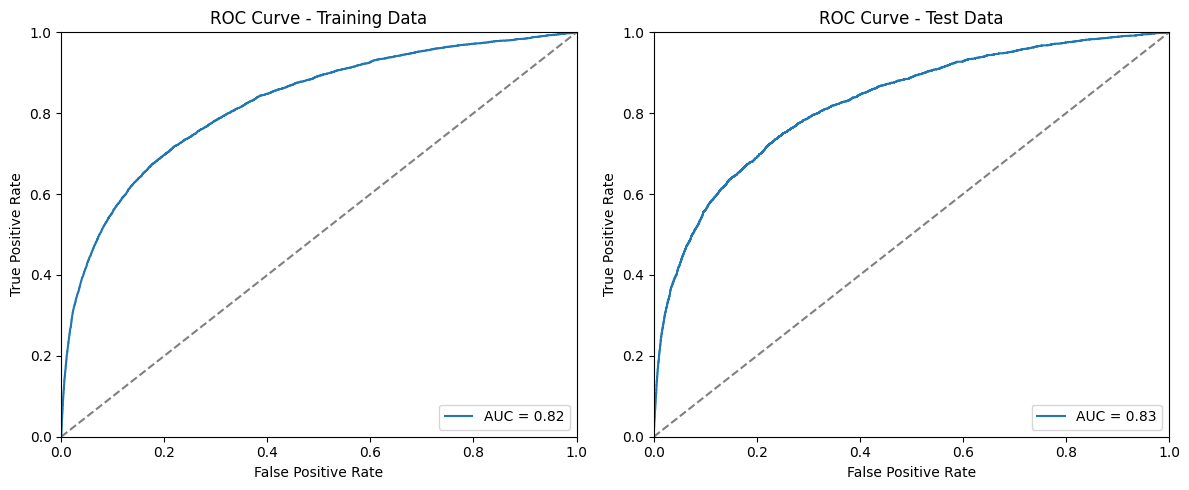

In [ ]:
# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curve for training data
plot_roc_curve_custom(best_unbalanced_model, X_train, y_train, title='ROC Curve - Training Data', ax=axes[0])

# Plot ROC curve for test data
plot_roc_curve_custom(best_unbalanced_model, X_test, y_test, title='ROC Curve - Test Data', ax=axes[1])

plt.tight_layout()
plt.show()

An AUC curve of 0.85 means that the model has an 85% probability of correctly classifying a positive sample as more likely to belong to the positive class than a negative sample. In other words, the model has a high true positive rate (TPR) and a low false positive rate (FPR).

#### Feature Importance

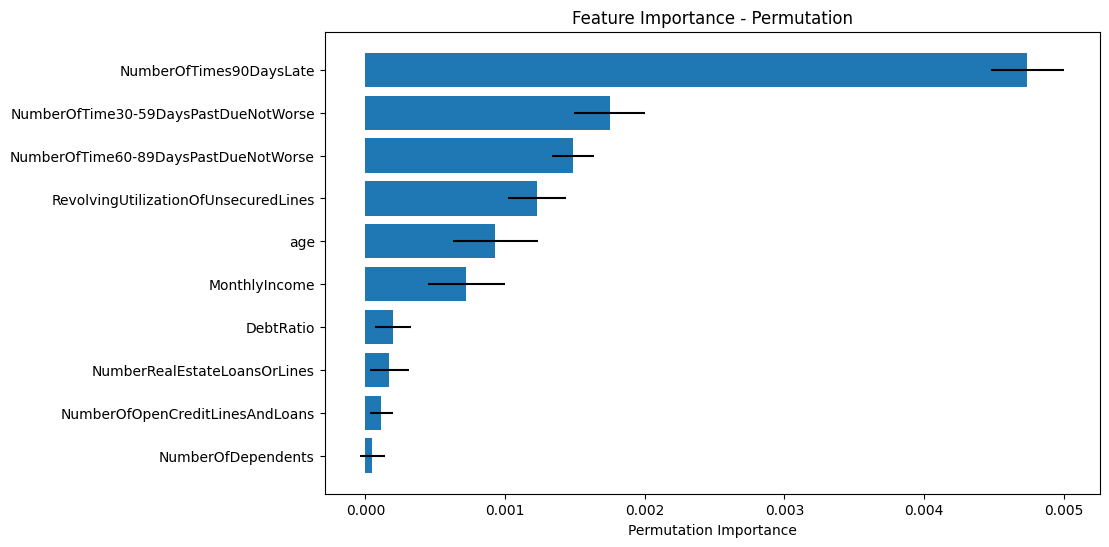

In [ ]:
# Calculate permutation importance for each feature
perm_importance = permutation_importance(best_unbalanced_model, X_test, y_test, n_repeats=30, random_state=42)

# Get the feature names
feature_names = X_train.columns

# Sort the features based on their importance
sorted_idx = perm_importance.importances_mean.argsort()

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], xerr=perm_importance.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance - Permutation')
plt.show()

In [ ]:
# Save the model to a .pkl file
filename = 'logreg_model.pkl'
joblib.dump(best_unbalanced_model, filename)

['logreg_model.pkl']